In [5]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import shap
import joblib

📌 2️⃣ Load + Combine All Ranked CSVs

In [6]:
data_path = "../data/ranked_data"

files = sorted([f for f in os.listdir(data_path) if f.endswith(".csv")])

dfs = []
for f in files:
    year = int("".join(filter(str.isdigit, f)))  # extracts 2018, 2019, etc.
    df = pd.read_csv(os.path.join(data_path, f))
    df["Year"] = year
    dfs.append(df)

nirf_all = pd.concat(dfs, ignore_index=True)
nirf_all.head()

,Institute Name,Institute Code,SS,FSR,FQE,FRU,PU,QP,IPR,FPPP,...,RD,WD,ESCS,PCS,PR,Rank,Year,Institution Name,Institution Code,OE
0,Indian Institute of Science,IR-1-O-O-U-0220,10.25,30.00,18.30,26.00,35.00,35.00,14.0,7.08,...,21.12,9.50,4.08,9.0,100,1.0,2018,NaN,NaN,NaN
1,Indian Institute of Technology Madras,IR-2-O-OE-U-0456,17.00,27.77,17.92,19.00,28.28,28.93,13.0,11.21,...,22.86,13.37,8.57,20.0,86.61,2.0,2018,NaN,NaN,NaN
2,Indian Institute of Technology Bombay,IR-3-O-OEM-U-0306,17.00,28.55,19.20,16.59,29.83,31.68,15.0,9.08,...,22.23,13.23,6.07,7.0,79.61,3.0,2018,NaN,NaN,NaN
3,Indian Institute of Technology Delhi,IR-3-O-OEM-I-1074,14.85,24.41,15.89,18.22,29.61,31.18,9.0,8.88,...,23.01,13.65,4.30,20.0,72.79,4.0,2018,NaN,NaN,NaN
4,Indian Institute of Technology Kharagpur,IR-5-O-OEMAL-U-0573,16.56,23.25,15.21,12.95,28.36,32.47,7.0,6.74,...,22.39,10.71,3.06,20.0,62.12,5.0,2018,NaN,NaN,NaN


📌 3️⃣ Clean Data (Convert to Numeric, Fix NaNs)

In [7]:
clean_df = nirf_all.copy()

for col in clean_df.columns:
    clean_df[col] = pd.to_numeric(clean_df[col], errors="ignore")

num_cols = clean_df.select_dtypes(include=[np.number]).columns

clean_df[num_cols] = clean_df[num_cols].fillna(clean_df[num_cols].median())

clean_df.head()

/var/folders/03/d12ppvv967x43mxw8d91d2q80000gn/T/ipykernel_99749/4142447704.py:4: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  clean_df[col] = pd.to_numeric(clean_df[col], errors="ignore")


,Institute Name,Institute Code,SS,FSR,FQE,FRU,PU,QP,IPR,FPPP,...,RD,WD,ESCS,PCS,PR,Rank,Year,Institution Name,Institution Code,OE
0,Indian Institute of Science,IR-1-O-O-U-0220,10.25,30.00,18.30,26.00,35.00,35.00,14.0,7.08,...,21.12,9.50,4.08,9.0,100,1.0,2018,NaN,NaN,0.0
1,Indian Institute of Technology Madras,IR-2-O-OE-U-0456,17.00,27.77,17.92,19.00,28.28,28.93,13.0,11.21,...,22.86,13.37,8.57,20.0,86.61,2.0,2018,NaN,NaN,0.0
2,Indian Institute of Technology Bombay,IR-3-O-OEM-U-0306,17.00,28.55,19.20,16.59,29.83,31.68,15.0,9.08,...,22.23,13.23,6.07,7.0,79.61,3.0,2018,NaN,NaN,0.0
3,Indian Institute of Technology Delhi,IR-3-O-OEM-I-1074,14.85,24.41,15.89,18.22,29.61,31.18,9.0,8.88,...,23.01,13.65,4.30,20.0,72.79,4.0,2018,NaN,NaN,0.0
4,Indian Institute of Technology Kharagpur,IR-5-O-OEMAL-U-0573,16.56,23.25,15.21,12.95,28.36,32.47,7.0,6.74,...,22.39,10.71,3.06,20.0,62.12,5.0,2018,NaN,NaN,0.0


📌 4️⃣ Save Combined File

In [8]:
save_path = "../data/processed/nirf_combined.csv"
clean_df.to_csv(save_path, index=False)
save_path

'../data/processed/nirf_combined.csv'

📌 5️⃣ Train Model (RF + XGB → auto choose best)

In [9]:
target = "Rank"
features = [col for col in clean_df.columns 
            if col not in ["Rank", "Institution Name", "Institution Code", "Year"]]

X = clean_df[features]
y = clean_df[target]

In [10]:
drop_cols = ["Institute Name", "Institute Code", "Rank", "Year"]

In [11]:
numeric_cols = clean_df.drop(columns=drop_cols, errors="ignore").select_dtypes(include=['int64','float64']).columns.tolist()

X = clean_df[numeric_cols]
y = clean_df["Rank"]

In [12]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [13]:
print("Shape:", X.shape)
print("Dtypes:\n", X.dtypes)

Shape: (501, 15)
Dtypes:
 SS      float64
FSR     float64
FQE     float64
FRU     float64
PU      float64
QP      float64
IPR     float64
FPPP    float64
GUE     float64
GPHD    float64
RD      float64
WD      float64
ESCS    float64
PCS     float64
OE      float64
dtype: object


In [14]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

rf = RandomForestRegressor(n_estimators=350, max_depth=12)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.08, max_depth=7)


rf.fit(X, y)

,n_estimators,350
,criterion,'squared_error'
,max_depth,12
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [15]:
rf = RandomForestRegressor(n_estimators=350, max_depth=12)
xgb = XGBRegressor(n_estimators=300, learning_rate=0.08, max_depth=7)

rf.fit(X_scaled, y)
xgb.fit(X_scaled, y)

rf_score = rf.score(X_scaled, y)
xgb_score = xgb.score(X_scaled, y)

best_model = rf if rf_score > xgb_score else xgb
best_name = "RandomForest" if best_model == rf else "XGBoost"

best_name, rf_score, xgb_score

('XGBoost', 0.9753011908578066, 0.9999993312022799)

📌 6️⃣ Save Model + Scaler

In [16]:
joblib.dump(best_model, "../models/nirf_pr_model.pkl")
joblib.dump(scaler, "../models/nirf_scaler.pkl")

['../models/nirf_scaler.pkl']

📌 7️⃣ Feature Importance Plot

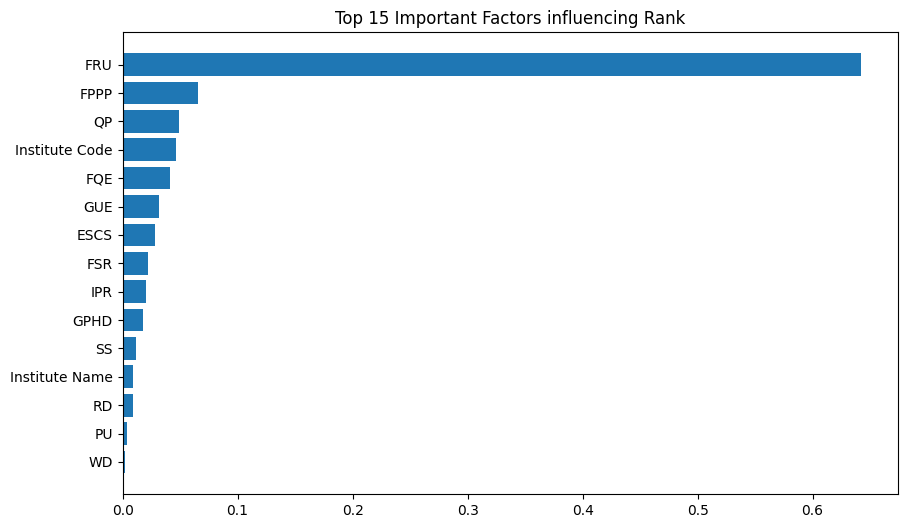

In [17]:
importances = best_model.feature_importances_
idx = np.argsort(importances)[::-1]

plt.figure(figsize=(10,6))
plt.barh(np.array(features)[idx][:15][::-1], importances[idx][:15][::-1])
plt.title("Top 15 Important Factors influencing Rank")
plt.show()

📌 8️⃣ SHAP Analysis (Explaining WHY Rank happens)

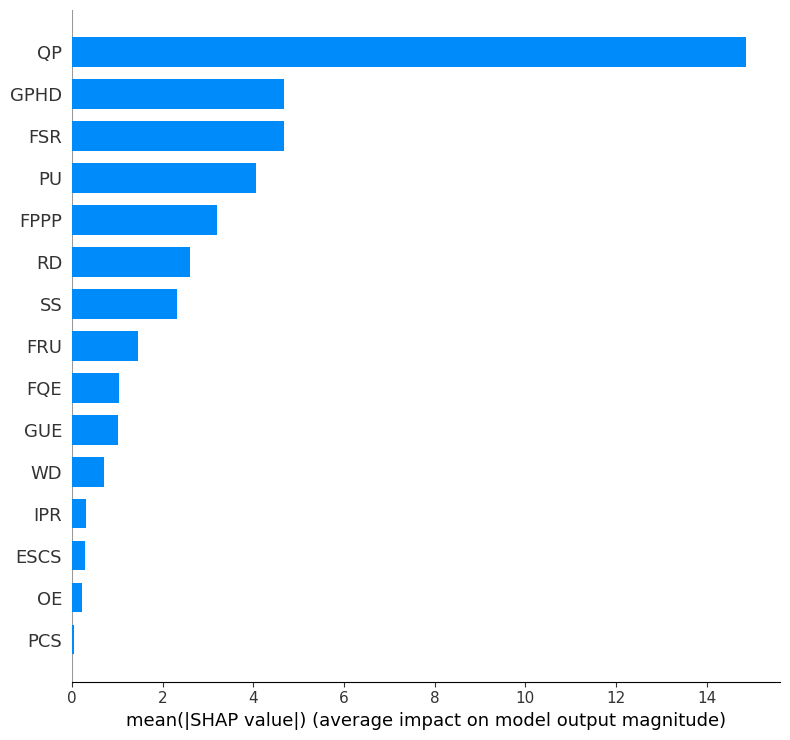

In [18]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_scaled)

shap.summary_plot(shap_values, X, plot_type="bar")

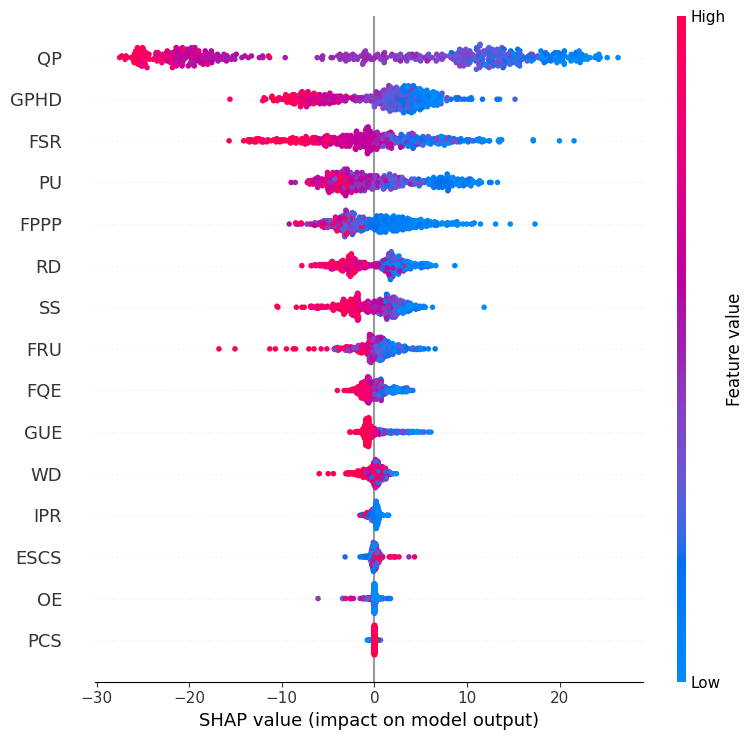

In [19]:
shap.summary_plot(shap_values, X)

📌 9️⃣ Add Predicted Rank Back to Data

In [20]:
clean_df["Predicted_Rank"] = best_model.predict(X_scaled)

clean_df.to_csv("../data/processed/nirf_combined_predicted.csv", index=False)
clean_df.head()

,Institute Name,Institute Code,SS,FSR,FQE,FRU,PU,QP,IPR,FPPP,...,WD,ESCS,PCS,PR,Rank,Year,Institution Name,Institution Code,OE,Predicted_Rank
0,Indian Institute of Science,IR-1-O-O-U-0220,10.25,30.00,18.30,26.00,35.00,35.00,14.0,7.08,...,9.50,4.08,9.0,100,1.0,2018,NaN,NaN,0.0,1.008593
1,Indian Institute of Technology Madras,IR-2-O-OE-U-0456,17.00,27.77,17.92,19.00,28.28,28.93,13.0,11.21,...,13.37,8.57,20.0,86.61,2.0,2018,NaN,NaN,0.0,2.002758
2,Indian Institute of Technology Bombay,IR-3-O-OEM-U-0306,17.00,28.55,19.20,16.59,29.83,31.68,15.0,9.08,...,13.23,6.07,7.0,79.61,3.0,2018,NaN,NaN,0.0,2.997099
3,Indian Institute of Technology Delhi,IR-3-O-OEM-I-1074,14.85,24.41,15.89,18.22,29.61,31.18,9.0,8.88,...,13.65,4.30,20.0,72.79,4.0,2018,NaN,NaN,0.0,4.002643
4,Indian Institute of Technology Kharagpur,IR-5-O-OEMAL-U-0573,16.56,23.25,15.21,12.95,28.36,32.47,7.0,6.74,...,10.71,3.06,20.0,62.12,5.0,2018,NaN,NaN,0.0,5.033079
